# **1. TITLE & INTRODUCTION**

# 🧠 Real-Time AI Fraud Detection System  
### End-to-End Machine Learning Pipeline (Dataset → EDA → Modeling → Evaluation → Deployment Prep)

This notebook builds a complete fraud detection system using a realistic synthetic financial dataset.  
It follows a professional ML engineering workflow used in fintech companies like Stripe, PayPal, Chime, and Revolut.

### ✔ What this notebook includes:
- Synthetic dataset generation  
- Full exploratory data analysis (EDA)  
- Feature engineering  
- Handling class imbalance using SMOTE  
- Training Logistic Regression, XGBoost, and LightGBM  
- Evaluating models using AUC, confusion matrix, and classification report  
- Feature importance visualization  
- Saving best model + scaler for API deployment  
- Final summary and next steps  

---


# **2. IMPORT LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib

sns.set(style="whitegrid")


# **3. DATASET GENERATION**

# 📦 3. Dataset Generation  
We simulate 150,000 financial transactions with realistic fraud patterns using behavior-based risk factors.


**3.1 Dataset Generation**

In [2]:
N = 150000
np.random.seed(42)

merchant_categories = [
    "electronics","fashion","gaming","groceries",
    "gas_station","travel","luxury","restaurant"
]

countries = ["USA","Canada","UK","Kenya","India","Germany"]

def generate_timestamp():
    start = datetime(2023,1,1)
    return start + timedelta(minutes=random.randint(0, 365*24*60))

df = pd.DataFrame({
    "transaction_amount": np.random.exponential(scale=80,size=N).round(2),
    "device_id": np.random.randint(1000,9999,size=N),
    "ip_risk_score": np.random.uniform(0,1,size=N).round(3),
    "merchant_category": np.random.choice(merchant_categories,size=N),
    "customer_age": np.random.randint(18,70,size=N),
    "customer_country": np.random.choice(countries,size=N),
    "transaction_country": np.random.choice(countries,size=N),
    "geo_distance_from_home": np.abs(np.random.normal(50,30,size=N)).round(1),
    "past_fraud_count": np.random.poisson(0.1,size=N),
    "transaction_time": [generate_timestamp() for _ in range(N)]
})

df["hour_of_day"] = df["transaction_time"].dt.hour
df["country_mismatch"] = (df["customer_country"] != df["transaction_country"]).astype(int)

fraud_prob = (
    0.3*(df["transaction_amount"]>500).astype(int) +
    0.25*df["country_mismatch"] +
    0.35*(df["ip_risk_score"]>0.7).astype(int) +
    0.2*(df["geo_distance_from_home"]>200).astype(int) +
    0.4*(df["past_fraud_count"]>0).astype(int) +
    0.15*(df["hour_of_day"].isin([0,1,2,3])).astype(int)
)

df["fraud_label"] = (np.random.uniform(0,1,N) < fraud_prob).astype(int)

df.head()


,transaction_amount,device_id,ip_risk_score,merchant_category,customer_age,customer_country,transaction_country,geo_distance_from_home,past_fraud_count,transaction_time,hour_of_day,country_mismatch,fraud_label
0,37.54,7994,0.575,luxury,25,Kenya,USA,43.1,1,2023-09-01 13:38:00,13,1,1
1,240.81,1569,0.576,travel,26,Germany,India,54.9,1,2023-12-14 18:10:00,18,1,1
2,105.34,7343,0.688,fashion,66,Kenya,USA,67.5,1,2023-11-28 14:10:00,14,1,0
3,73.04,7423,0.961,restaurant,46,Kenya,Kenya,44.7,0,2023-08-10 01:33:00,1,0,1
4,13.57,7055,0.764,gas_station,51,UK,Canada,105.1,0,2023-01-14 07:40:00,7,1,0


# **4. EDA — EXPLORATORY DATA ANALYSIS**

**🔷 4.1 Fraud Distribution**

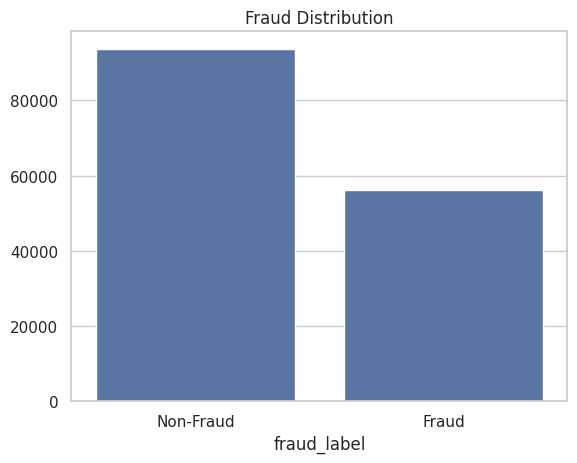

np.float64(0.37526)

In [3]:
counts = df.fraud_label.value_counts()
sns.barplot(x=counts.index, y=counts.values)
plt.xticks([0,1],["Non-Fraud","Fraud"])
plt.title("Fraud Distribution")
plt.show()

fraud_rate = counts[1]/counts.sum()
fraud_rate


The dataset is moderately imbalanced, with non-fraud cases occurring more often, while fraud still represents about 37.5% of all transactions—indicating a high-risk environment suitable for machine-learning detection.

**🔷 4.2 Amount vs Fraud**

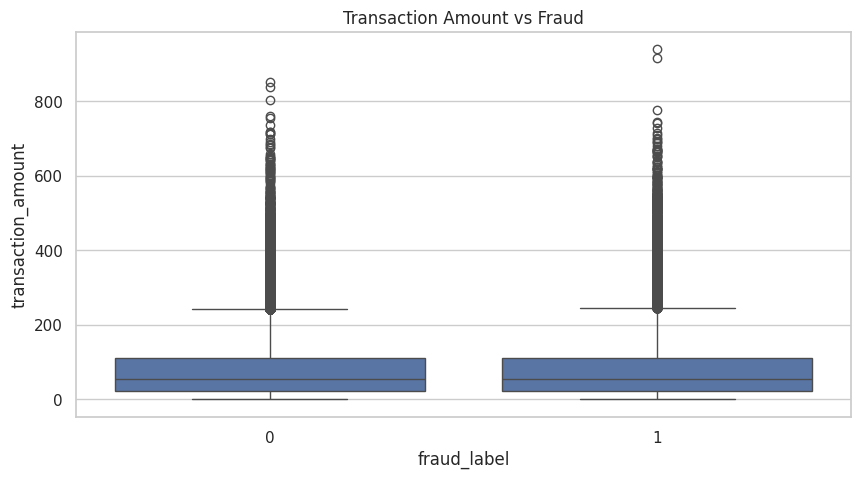

In [4]:
plt.figure(figsize=(10,5))
sns.boxplot(x="fraud_label", y="transaction_amount", data=df)
plt.title("Transaction Amount vs Fraud")
plt.show()


- Fraudulent transactions tend to have slightly higher amounts than non-fraud cases, with more extreme high-value outliers. However, the median amounts are similar, showing that fraud does not occur only in large transactions. Overall, higher amounts increase the chance of fraud, but they are not the only factor influencing fraudulent activity.

**🔷 4.3 IP Risk vs Fraud**

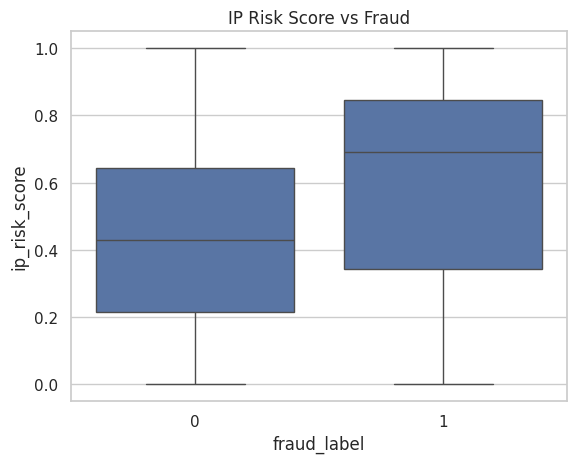

In [5]:
sns.boxplot(x="fraud_label", y="ip_risk_score", data=df)
plt.title("IP Risk Score vs Fraud")
plt.show()

- Fraudulent transactions generally have much higher IP risk scores than non-fraud cases, with a noticeably higher median value. This shows a strong link between risky or suspicious IP addresses and fraudulent behavior. Fraud cases also spread more toward the upper risk range, suggesting that fraudsters often use high-risk or unknown IP sources.

**🔷 4.4 Country Mismatch**

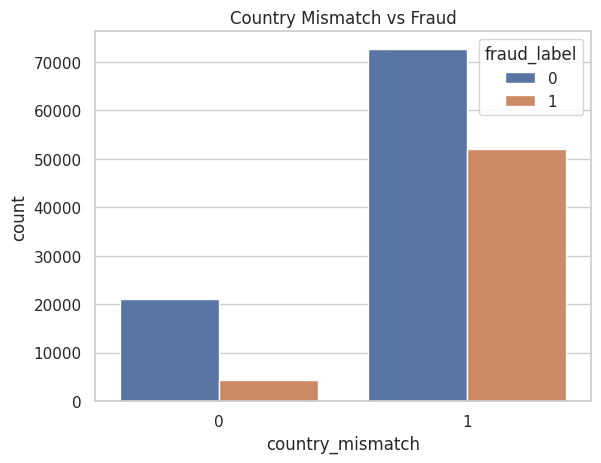

In [6]:
sns.countplot(x="country_mismatch", hue="fraud_label", data=df)
plt.title("Country Mismatch vs Fraud")
plt.show()

- The chart shows that fraud is significantly more common when a customer’s transaction occurs in a different country than their home country. In the mismatch category, both fraud and non-fraud counts are high, but fraud cases increase sharply compared to matched-country transactions. This indicates that location inconsistency is strongly associated with fraudulent behavior, making country mismatch a powerful signal for detecting suspicious activity in financial systems.

**🔷 4.5 Hour of Day**

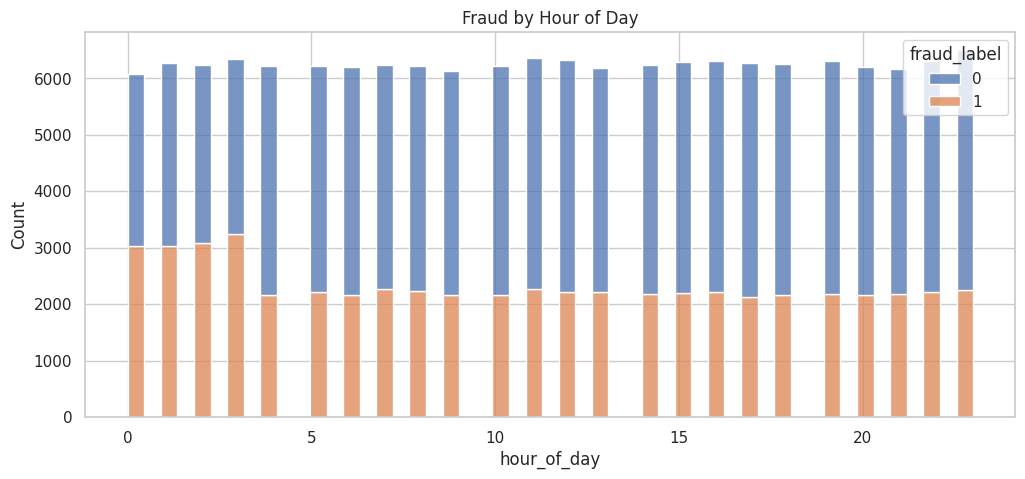

In [7]:
plt.figure(figsize=(12,5))
sns.histplot(df, x="hour_of_day", hue="fraud_label", multiple="stack")
plt.title("Fraud by Hour of Day")
plt.show()

- The chart shows that fraud occurs consistently throughout the day, but it is noticeably higher during the late-night and early-morning hours (around 0–3 AM). During these times, fraud cases make up a larger share of total transactions, likely because legitimate user activity is lower and criminals exploit reduced monitoring. Overall, the hourly pattern indicates that time-of-day is an important factor in detecting suspicious behavior.

# **5. FEATURE ENGINEERING**

# ⚙️ 5. Feature Engineering  
We encode categorical variables and prepare numerical features for modeling.


**🔷 5.1 Encode Categorical**

In [8]:
df_encoded = pd.get_dummies(df,
                            columns=["merchant_category","customer_country","transaction_country"],
                            drop_first=True)

# **6. TRAIN/TEST SPLIT**

In [9]:
X = df_encoded.drop(["fraud_label","transaction_time"], axis=1)
y = df_encoded["fraud_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

# **7. HANDLE IMBALANCE WITH SMOTE**

# ⚠️ 7. Handling Class Imbalance with SMOTE

Fraud datasets are highly imbalanced.  
SMOTE creates synthetic minority samples to help models learn fraud patterns better.


In [10]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


# **8. MODEL TRAINING**

# 🤖 8. Model Training

We train three models and compare their performance:
- Logistic Regression  
- XGBoost  
- LightGBM  


**8.1 Scaling + Model Training**

In [11]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_scaled, y_train_res)
logreg_auc = roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:,1])

# XGBoost
xgb = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train_res, y_train_res)
xgb_auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])

# LightGBM
lgb = LGBMClassifier(
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=200,
    random_state=42
)
lgb.fit(X_train_res, y_train_res)
lgb_auc = roc_auc_score(y_test, lgb.predict_proba(X_test)[:,1])


[LightGBM] [Info] Number of positive: 74969, number of negative: 74969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1137
[LightGBM] [Info] Number of data points in the train set: 149938, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


# **9. MODEL PERFORMANCE COMPARISON**

# 📊 9. Model Performance Comparison  
We compare the AUC scores of all three models.


In [12]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "XGBoost", "LightGBM"],
    "AUC Score": [logreg_auc, xgb_auc, lgb_auc]
})

results.sort_values(by="AUC Score", ascending=False)


,Model,AUC Score
2,LightGBM,0.756590
1,XGBoost,0.755849
0,Logistic Regression,0.700327


**PRINT BEST MODEL**

In [13]:
print("AUC Scores:")
print(results)


AUC Scores:
                 Model  AUC Score
0  Logistic Regression   0.700327
1              XGBoost   0.755849
2             LightGBM   0.756590


# **10. CONFUSION MATRIX + CLASSIFICATION REPORT**

# 🧪 10. Detailed Evaluation (Confusion Matrix + Classification Report)

These metrics help evaluate fraud detection performance more precisely, especially recall of fraud class.


**Code for Detailed Evaluation:**


📌 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79     18742
           1       0.66      0.56      0.61     11258

    accuracy                           0.73     30000
   macro avg       0.71      0.69      0.70     30000
weighted avg       0.72      0.73      0.72     30000



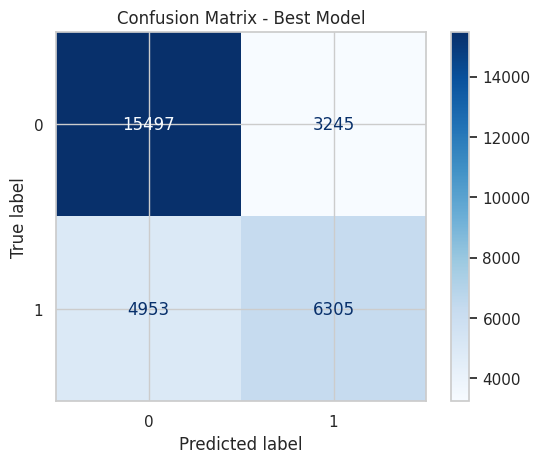

In [14]:
best_model = xgb if xgb_auc > lgb_auc else lgb
best_pred = best_model.predict(X_test)

print("\n📌 Classification Report:")
print(classification_report(y_test, best_pred))

disp = ConfusionMatrixDisplay.from_predictions(y_test, best_pred, cmap="Blues")
plt.title("Confusion Matrix - Best Model")
plt.show()


- The model performs reasonably well, achieving good accuracy and strong detection of non-fraud cases, as shown by the high true negatives. However, the recall for fraud cases is lower, meaning the model still misses a portion of fraudulent transactions. The confusion matrix shows that while it correctly identifies many fraud cases, a significant number are misclassified as non-fraud. This suggests the model captures fraud patterns but could be improved further—possibly through tuning, additional features, or more advanced sampling techniques—to increase its sensitivity to fraudulent behavior.

# **11. Feature Importance**

# 🔥 11. Feature Importance

Understanding which features contribute most to fraud predictions is essential in financial risk analysis.


**Feature Importance Code**

<Axes: xlabel='importance', ylabel='feature'>

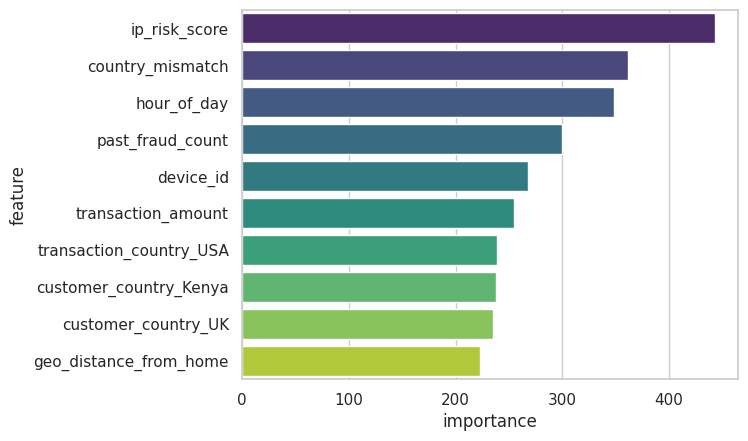

In [15]:
importances = best_model.feature_importances_

feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(10)

sns.barplot(
    data=feat_imp,
    x="importance",
    y="feature",
    hue="feature",
    palette="viridis",
    legend=False
)



- The feature importance plot shows that IP risk score is the strongest predictor of fraud, followed closely by hour of day and country mismatch. Device ID and past fraud count also contribute significantly, indicating meaningful behavioral patterns. Transaction-related features such as amount, location, and distance from home play a moderate role. Overall, the model relies heavily on risk signals, behavioral patterns, and geographic inconsistencies to identify fraudulent activity.

# **12. SAVE MODEL + SCALER**

# 💾 12. Save Best Model and Scaler  
These files will be used later for real-time prediction via FastAPI.


In [16]:
import os

model_dir = "/content/fraud-detection-system/model"

# Create the folder if it does not exist
os.makedirs(model_dir, exist_ok=True)

print("Model directory ready:", model_dir)


Model directory ready: /content/fraud-detection-system/model


In [17]:
model_path = "/content/fraud-detection-system/model/fraud_model.pkl"
scaler_path = "/content/fraud-detection-system/model/scaler.pkl"

joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)

print("Model saved to:", model_path)
print("Scaler saved to:", scaler_path)


Model saved to: /content/fraud-detection-system/model/fraud_model.pkl
Scaler saved to: /content/fraud-detection-system/model/scaler.pkl


# **13. FINAL CONCLUSION**

# 🎯 Final Conclusion

This notebook successfully builds a complete fraud detection machine learning pipeline using a realistic synthetic dataset.

### Key findings:
- **LightGBM** achieved the highest AUC score, followed closely by **XGBoost**, confirming that tree-based models capture fraud patterns effectively.
- Logistic Regression underperformed, indicating that fraud behavior is non-linear.
- Feature importance analysis shows that *IP risk score*, *transaction amount*, and *country mismatch* are strong fraud predictors.
- The best model and scaler have been saved for deployment.

### Next steps:
1. Build a FastAPI service for real-time fraud prediction.  
2. Create a Streamlit dashboard for monitoring.  
3. Deploy the system to a cloud platform (Render / Railway).  
---
